In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import gc
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split, Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import os
import csv
import copy
import cv2 as cv
from google.colab import files

In [ ]:
# Cloning the repository containing the dataset
!git clone https://github.com/NavoditC/Fooled_by_AI.git

fatal: destination path 'Fooled_by_AI' already exists and is not an empty directory.


In [ ]:
# Read the data in a dataframe
path = 'Fooled_by_AI/images/dataset.csv'
column_names = ['images','targets']
df = pd.read_csv(path,names=column_names)

In [ ]:
df.head()

,images,targets
0,images_real_moon0.png,1
1,images_real_moon1.png,1
2,images_real_moon2.png,1
3,images_real_moon3.png,1
4,images_real_moon4.png,1


In [ ]:
# Reading the csv file which containing the image paths and the steering angle, throttle, brake and speed
dataset = []
with open('Fooled_by_AI/images/dataset.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader, None) # To skip the first line which contains the column names of the dataframe
    for line in csv_reader:
        dataset.append(line)

In [ ]:
class MyDataset(Dataset):

    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, index):
        batch_samples = self.samples[index]
        filename = batch_samples[0]
        target = int(batch_samples[1])
        filepath = 'Fooled_by_AI/images/' + filename.split('/')[-1]
        image = cv.imread(filepath)
        image = image[60:420,143:513]
        image = cv.resize(image,(224,224))
        image = self.transform(image)
        return image, target
      
    def __len__(self):
        return len(self.samples)

In [ ]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=2):
    return ResNet(18, Block, img_channels, num_classes)

In [ ]:
# Performing train-test split and storing the train and test data
total_samples = len(dataset)
train_samples = int(0.8*total_samples)
test_samples = total_samples - train_samples
train_test_lengths = [train_samples,test_samples]
train_data, test_data = random_split(dataset, lengths = train_test_lengths)
params = {'batch_size': 4, 'shuffle': True, 'num_workers': 2}

transform = transforms.Compose([
    transforms.ToPILImage(),                            
    #transforms.RandomCrop((28, 28), padding=2, pad_if_needed=True, fill=0, padding_mode='constant'), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x / 255.0))
])
          
# Define the transformation to normailize the image such that the pixel intensities lie between 0 and 1
training_set = MyDataset(train_data, transform)
test_set = MyDataset(test_data, transform)

# Define the training and test generator which is called batch-wise during training and testing respectively
training_generator = DataLoader(training_set, **params)
test_generator = DataLoader(test_set, **params)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet18(img_channels=3, num_classes=2)

model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

Finished Training
Accuracy of the network on the test images: 100.000 %


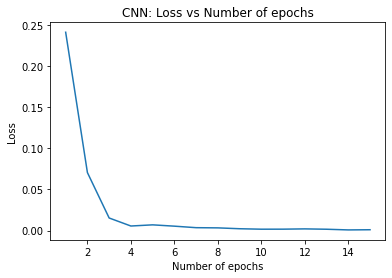

In [ ]:
def main(): 

    count = 0
    loss_list = []
    epoch_list = []
    

    num_epoch = 15
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        epoch_list.append(epoch+1)
        running_loss = 0.0
        correct = 0
        total = 0
        loss_epoch = 0.0
        c=0
        for i, (inputs, labels) in enumerate(training_generator):

            torch.cuda.empty_cache()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            #inputs = inputs.permute(0,3,1,2)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            loss_epoch += loss.item()
            c+=1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f accuracy: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000, 100*correct/total))
                running_loss = 0.0
        loss_list.append(loss_epoch/c) 

    print('Finished Training')



    correct = 0
    total = 0
    with torch.no_grad():
        for (inputs, labels) in test_generator:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            #inputs = inputs.permute(0,3,1,2)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the test images: %.3f %%' % (
            100 * correct / total))
    plt.plot(epoch_list,loss_list)
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.title("CNN: Loss vs Number of epochs")
    plt.show()

if __name__ == '__main__':

  main()

Reference: https://niko-gamulin.medium.com/resnet-implementation-with-pytorch-from-scratch-23cf3047cb93